# **Homework: Week #19 | Solving Optimization Problems with VQE**
---

### **Description**:  
In this week's homework, you will use Qiskit's Variational Quantum Eigensolver (VQE) algorithm to solve a classic optimization problem in finance: Portfolio Optimization.


---

## **Part #0: Importing from Python Libraries**
---

**Run the cell directly below before doing anything else. This will import all of the functions that you will use here.**

In [1]:
# General Qiskit and VQE imports
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit import Aer
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import WikipediaDataProvider
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit import QuantumCircuit
from qiskit.visualization import visualize_transition


# Non-qiskit imports
import math
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib widget
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


print("Libraries imported successfully!")




# Helper functions - these functions will help us solve the portfolio optimization problem
# Don't worry about the details of these functions for now - focus on where they are used in the code

# This function imports stock prices using Quandl and Wikipedia. You can edit the start and end datetimes to consider stock prices over a different time period!
# Data is only availble until April 2018, so use time periods earlier than that.
def import_stock_prices(stocks):
    quandl_token = "HRXZqqxBka_9huabBgoW" 
    wiki = WikipediaDataProvider(
                        token = quandl_token,
                        tickers = stocks,
                        start = datetime.datetime(2016,1,1),
                        end = datetime.datetime(2017,1,1))
    wiki.run()
    return wiki


# This function uses matplotlib to plot normalized stock prices
def plot_stock_prices(stock_prices, form="norm"):
    fig, ax = plt.subplots(figsize=(8,6))
    if stock_prices._data:
        for (cnt, s) in enumerate(stocks):
            start = stock_prices._data[cnt][0]
            eq = stock_prices._data[cnt] / start
            min_ = np.min(stock_prices._data[cnt])
            max_ = np.max(stock_prices._data[cnt])
            norm = (stock_prices._data[cnt] - min_)/(max_- min_)
            if form == "norm": ax.plot(norm, label=s)
            elif form == "eq": ax.plot(eq, label=s)
            elif form == "raw": ax.plot(stock_prices._data[cnt], label=s)
            else: raise ValueError("Invalid 'form' value")
        ax.legend()
        key = {"norm":"Normalised", "raw":"Raw", "eq":"Equalized"}
        ax.set_title(f"{key[form]} Yearly Evolution of Stock Prices")
        plt.xticks(rotation=90)
        # plt.tight_layout()
        plt.show()
    else:
        print('No wiki data loaded.')

# This Function displays the result of a VQE or Classical Eigensolver
def display_values(vqe_result, stocks):
    lines = []
    for result in vqe_result.samples[:5]:
            qubits, value, probability = result.x, result.fval, result.probability
            q_str = str(qubits.astype(int)).ljust(16)
            arr = np.array(qubits)
            opt = [str(stock[0])+' ' for stock in np.take(stocks, np.argwhere(arr))]
            opt_str = "".join(opt).ljust(16)
            lines.append((opt_str, f'{q_str} {opt_str} {round(value,4)} \t {round(probability,4)}'))

    print(f' Optimal Stock Combination: {lines[0][0]}')
    print('\n------------------------ Top Results ------------------------')
    print('solution \t stocks \t value \t\t probability')
    print('--------------------------------------------------------------')
    [print(p[1]) for p in lines]
    print('--------------------------------------------------------------')

# This function draws the value of the portfolio against other the stocks
def plot_portfolio_against_market(result, stock_prices):
    portfolio_sel = np.argwhere(result.samples[0].x).reshape(-1)
    fig, ax = plt.subplots(figsize=(8,6))
    if stock_prices._data:
        portfolio_sum = []
        for (cnt, s) in enumerate(stocks):
            start = stock_prices._data[cnt][0]
            eq = stock_prices._data[cnt] / start
            if cnt in portfolio_sel:
                portfolio_sum.append(eq)
                ax.plot(eq, label=f"{s} (Selected)", linestyle="--", alpha=0.5)
            else:
                ax.plot(eq, label=s, alpha=0.15)
        sab = sum(portfolio_sum)
        # This has no purpose besides shifting the color because I don't like brown
        next(ax._get_lines.prop_cycler)   
        ax.plot(sab/2, label="Portfolio Value")
        ax.set_title("Portfolio Performance") 
        ax.legend()
        plt.xticks(rotation=90)
        plt.show()

    else:
        print('No wiki data loaded.')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Libraries imported successfully!


## **Part #1: Tunable Circuits**
---

In this section, you will practice making tunable circuits in Qiskit.

### **Exercise #1** 

Create and visualize a 1-qubit circuit with an RX gate with an angle of $\mathbf{π}$ (the same as 180°).

In [ ]:
circuit = QuantumCircuit(1)

circuit.rx(math.pi,0)

### **Exercise #2** 

Create and visualize a 1-qubit circuit with an X gate and then an RZ gate with an angle of $\mathbf{\frac{π}{3}}$ (the same as 60°).

In [ ]:
circuit = QuantumCircuit(1)

circuit.x(0)
circuit.rx(math.pi/3, 0)


### **Exercise #3** 

Create and visualize the `EfficientSU2` tunable circuit with 1 qubit and 1 repetition.

In [ ]:
tunable_circuit = EfficientSU2(num_qubits = 1,
                               reps = 1)

tunable_circuit.decompose()

### **Exercise #4** 

Create and visualize an `EfficientSU2` tunable circuit with 2 qubits and 2 reps.

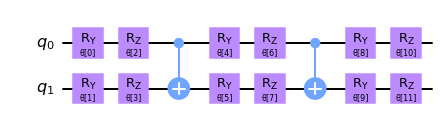

In [5]:
tunable_circuit = EfficientSU2(num_qubits = 2, reps = 2)

tunable_circuit.decompose().draw()

### **Exercise #5** 

There are several other parameters you can specify for `EfficientSU2`. One notable example is `entanglement`. It can take on string values such as `full`, `linear` , `reverse_linear`, `circular` or `sca`. By default, it is `reverse_linear`.

Create and visualize an `EfficientSU2` tunable circuit with 3 qubits, 2 reps, and `full` entanglement.

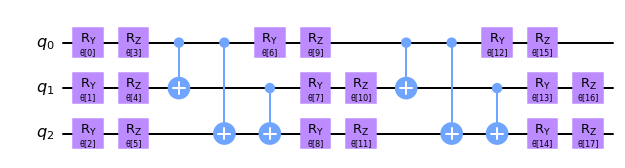

In [8]:
tunable_circuit = EfficientSU2(num_qubits = 3, reps = 2, entanglement = 'full')

tunable_circuit.decompose().draw()

Now, try out the `linear` entanglement for the same circuit. How did the circuit change?

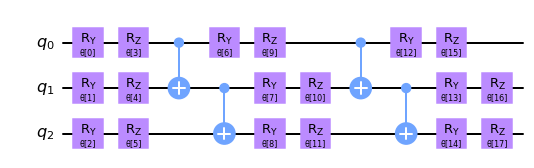

In [9]:
tunable_circuit = EfficientSU2(num_qubits = 3, reps = 2, entanglement = 'linear')

tunable_circuit.decompose().draw()

### **Exercise #6** 

Besides the string options, you can also "hardcode" the qubits you'd like to entangle by providing a list of integer pairs identifying pairs of entangled qubits. 

*For example:* `tunable_circuit = EfficientSU2(num_qubits = 4, reps = 5, entanglement = [[0,3], [1,2], [0,1]])`

Create and visualize an `EfficientSU2` tunable circuit with 3 qubits, 2 reps, and entangling **zeroth qubit with the first one** as well as **the second qubit with the first one**.

Additionally, you can add **barriers** separating each section of your circuit by adding `insert_barriers = True`.

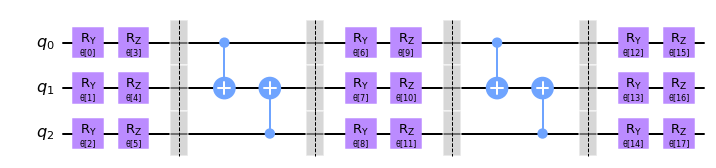

In [10]:
tunable_circuit = EfficientSU2(num_qubits = 3, reps = 2, entanglement = [[0,1], [2,1]],
                                insert_barriers = True)

tunable_circuit.decompose().draw(output='mpl')

### **Exercise #7** 

A few more parameters for you to experiment with:

* `initial_state` - a QuantumCircuit object to prepend to the circuit.
* `skip_unentangled_qubits` - if True, the single qubit gates are only applied to qubits that are entangled with another qubit. If False, the single qubit gates are applied to each qubit in the Ansatz.
* `skip_final_rotation_layer` - If False, a rotation layer is added at the end of the ansatz. If True, no rotation layer is added.

Full documentation can be found here: https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html

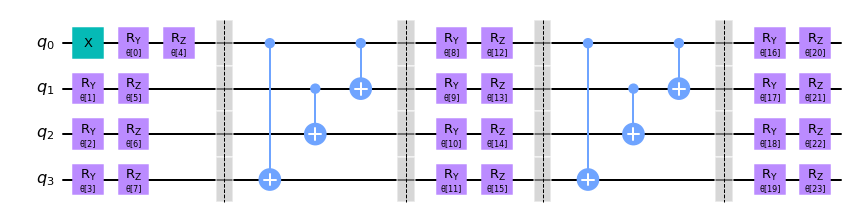

In [23]:
init_state = QuantumCircuit(4)


#Feel free to add more gates to your initial state quantum circuit
#It will be appended to the front of your SU2 circuit.
init_state.x(0)

tunable_circuit = EfficientSU2(num_qubits = 4, 
                               reps = 2, 
                               entanglement =  [[0,3], [1,2], [0,1]],
                               insert_barriers = True,
                               initial_state = init_state,
                               skip_unentangled_qubits = True,
                               skip_final_rotation_layer = False)

tunable_circuit.decompose().draw(output='mpl')

## **Part 2: Solving Portfolio Optimization Problem with VQE**

In this section, you will see how to use VQE to solve a version of the Knapsack Problem known as the *Portfolio Optimization Problem*. The basic idea is as follows:

* We want to buy some combination, or "portfolio", of $n$ stocks, or "assets". These correspond to the items in the Knapsack problem.
* Each stock is expected to earn a certain amount of money, the "expected return". This corresponds to the value of an item in the Knapsack problem.
* Each stock has a weight of 1 in the Knapsack problem (this could be adjusted to account for differences in prices, but that is beyond the scope of this activity).
* We have a maximum number of stocks we can buy, our "budget". This corresponds to the maximum weight in the Knapsack problem.
* There is a risk of losing money associated with each combination of stocks, called the "covariance". This is a new element that has no parallel in the Knapsack problem.

In our case, we will look $n = 5$ stocks with a budget of $2$ stocks in our portfolio and the rest (expected return and covariance) given by real stock market data from 2016 - 2017.

<br>

### **NOTE**: It's okay if you do not understand everything in this section. Most of the code is provided and this is just a chance to see VQE used for another problem.

<br><br>

---
**If you are interested in more technical detail**, here is a formal description of the problem:


The *mean-variance portfolio optimization problem* for $n$ assets is defined as:

$$\min\limits_{x\in\{0,1\}^n}qx^T\Sigma x-\mu^Tx$$

$$\texttt{with constraint: }1^Tx=B$$

where:

$x\in\{0,1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i]=1$) and which not to pick ($x[i]=0$),

$\mu\in\mathbb{R}^n$ defines the expected returns for the assets,

$\Sigma\in\mathbb{R}^{n\times n}$ specifies the covariances between the assets,

$q>0$ controls the risk appetite of the decision maker,

$B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

---

### **Exercise #0: Exploring the Data**

While the access to real-time data usually requires a payment, it is possible to access historical (adjusted) closing prices via Wikipedia and Quandl free of charge, following registration at: https://www.quandl.com/?modal=register.

You shouldn't need to register yourself as you should be able to use the token provided in the code.

**Run the cell below to import the stocks specified below.**

In [36]:
stocks = ["AAPL", "NFLX", "NVDA", "IBM", "GOOG"] # Other stock tickers you can add include F, NVDA, GME, etc. 
stock_prices = import_stock_prices(stocks)

#### **Visualize the data**
When working with new data, it's always a good idea to try and view it first -  look at the __*raw*__ data exactly as it comes in: 

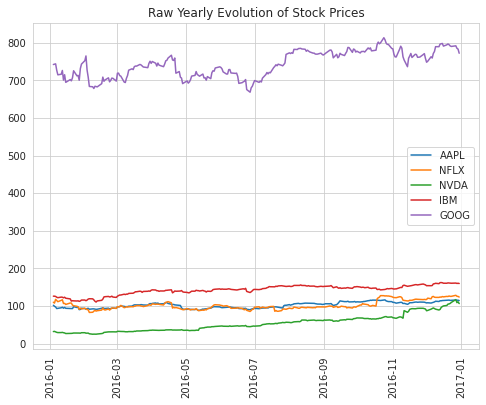

In [37]:
plot_stock_prices(stock_prices, form="raw")

**Initial observations on the raw data**:
It's important to notice that a share of `AMZN` and `GOOG` costs a lot more than `AAPL`, `IBM`, or `GOOG`. This graph makes it look like `AMZN` and `GOOG` increased by a lot more, but thats only the *dollar amount* what we really care about is the amount they increased *compared* to their starting price.

Therefore, this raw view of the data is relatively unhelpful. *Overall visualising financial data is tricky!*

Instead let's equalize their starting points, that way we can imagine that if we invested \$1 in January we can see how much that single dollar would be worth at the end of the year, regardless of the initial share price.

**Run the code below to visualize this data after equalizing.**

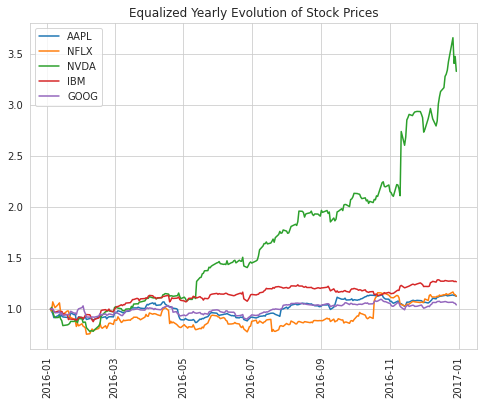

In [38]:
plot_stock_prices(stock_prices, form="eq")

#### **Intuitively, which stock is the best purchase?**

Looking at this graph we can see that if we had invested $\$1$ into `IBM` at the start of the year we would end the year with around $\$1.25$. That's an enourmous $25 \%$ increase! 

However, at several points during the year the stock decreases in value. We can intuitively see that by combining both the `AMZN` and `IBM` stocks we could "smooth-out" the graph and reduce our risk so that we get closer to that idealized steadily increasing flat line. 

This is what is known as portfolio optimization. We can computationally calculate which investments will have the highest return while minimizing the risk.

### **Exercise #1: Setting Up the Portfolio Optimization Problem**

You will use `qiskit`'s pre-made `PortfolioOptimization` class, which will turn our stock price data into a problem that our `VQE` solver can understand.

In [39]:
#num of assets (length of our NASDAQ issues array)
num_assets = len(stocks)

# set budget - how many stocks do you want to buy?
budget = 2

# Defining the portfolio optimization problem
portfolio = PortfolioOptimization(expected_returns=stock_prices.get_period_return_mean_vector(),
                                  covariances=stock_prices.get_period_return_covariance_matrix(),
                                  risk_factor=0.2, budget=budget)

# This creates a quadratic program, which is the form in which the problem can be directly
# passed to Qiskit's solvers
problem = portfolio.to_quadratic_program()



### **Exercise #2: Setting Up VQE**

Now, set up VQE. Specifically, we will create:
* The tunable circuit using `EfficientSU2` with the correct number of qubits (equal to `num_assets`), 3 repetitions, and `'full'` entanglement.
* A classical optimizer that uses the `SPSA` algorithm provided by Qiskit.
* The VQE solver combining all of these components.

<br>

**Hint**: This will look very similar to the way we set up VQE in lab.

In [40]:
tunable_circuit = EfficientSU2(num_qubits = num_assets, reps = 3, entanglement = 'full')


optimizer = SPSA(maxiter = 15)

method = VQE(ansatz = tunable_circuit, 
                          optimizer = optimizer, 
                          quantum_instance = Aer.get_backend('qasm_simulator'))

### **Exercise #3: Visualize the Circuit**

Before solving the problem, let's visualize the tunable circuit we will be using.

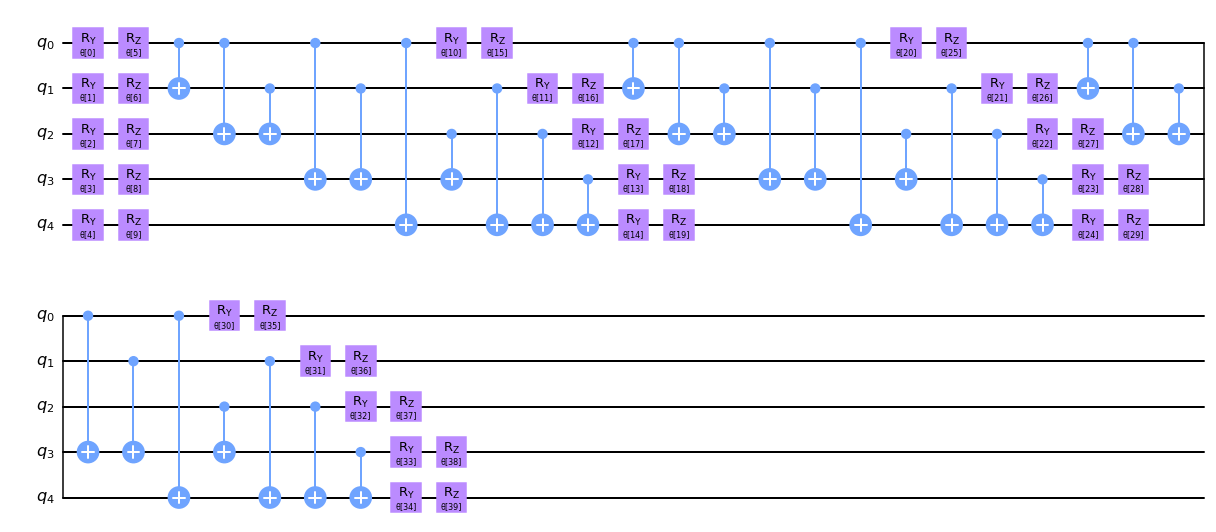

In [41]:
tunable_circuit.decompose().draw()

### **Exercise #4: Using VQE to Solve the Problem**

Finally, solve the problem using VQE.

**Run the code multiple times to see how the results change.**

In [ ]:
# Solve the Problem
calc = MinimumEigenOptimizer(method)
result = calc.solve(problem)

# Display Results
display_values(result, stocks)
plot_portfolio_against_market(result, stock_prices)

# End of Notebook
---
© 2023 The Coding School, All rights reserved